In [1]:
!ls

Untitled.ipynb	churn-bigml-20.csv  churn-bigml-80.csv


## 使用决策树模型

In [5]:
# import findspark
# findspark.init()

from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('prediction').getOrCreate()

In [6]:
train=spark.read.csv('churn-bigml-80.csv',header=False,inferSchema=True).cache()
train.show(5)

+---+---+---+---+---+---+-----+---+-----+-----+----+-----+-----+----+-----+----+----+----+----+-----+
|_c0|_c1|_c2|_c3|_c4|_c5|  _c6|_c7|  _c8|  _c9|_c10| _c11| _c12|_c13| _c14|_c15|_c16|_c17|_c18| _c19|
+---+---+---+---+---+---+-----+---+-----+-----+----+-----+-----+----+-----+----+----+----+----+-----+
| KS|128|415| No|Yes| 25|265.1|110|45.07|197.4|  99|16.78|244.7|  91|11.01|10.0|   3| 2.7|   1|false|
| OH|107|415| No|Yes| 26|161.6|123|27.47|195.5| 103|16.62|254.4| 103|11.45|13.7|   3| 3.7|   1|false|
| NJ|137|415| No| No|  0|243.4|114|41.38|121.2| 110| 10.3|162.6| 104| 7.32|12.2|   5|3.29|   0|false|
| OH| 84|408|Yes| No|  0|299.4| 71| 50.9| 61.9|  88| 5.26|196.9|  89| 8.86| 6.6|   7|1.78|   2|false|
| OK| 75|415|Yes| No|  0|166.7|113|28.34|148.3| 122|12.61|186.9| 121| 8.41|10.1|   3|2.73|   3|false|
+---+---+---+---+---+---+-----+---+-----+-----+----+-----+-----+----+-----+----+----+----+----+-----+
only showing top 5 rows



In [14]:
import pyspark.sql.types as tp
cols=[('state',tp.StringType()),
      ('account_length',tp.IntegerType()),
      ('area_code',tp.IntegerType()),
      ('international_plan',tp.StringType()),
      ('voice_mail_plan',tp.StringType()),
     ('number_vmail_messages',tp.IntegerType()),
     ('total_day_minutes',tp.DoubleType()),
     ('total_day_calls',tp.IntegerType()),
     ('total_day_charge',tp.DoubleType()),
     ('total_eve_minutes',tp.DoubleType()),
      ('total_eve_calls',tp.IntegerType()),
      ('total_eve_charge',tp.DoubleType()),
      ('total_night_minutes',tp.DoubleType()),
      ('total_night_calls',tp.IntegerType()),
      ('total_night_charge',tp.DoubleType()),
      ('total_intl_minutes',tp.DoubleType()),
      ('total_intl_calls',tp.IntegerType()),
      ('total_intl_charge',tp.DoubleType()),
      ('customer_service_calls',tp.IntegerType()),
      ('churn',tp.StringType())
     ]

churn_schemas=tp.StructType([tp.StructField(col[0],col[1],False) for col in cols])
train=spark.read.csv('churn-bigml-80.csv',header=False,schema=churn_schemas).cache()
test=spark.read.csv('churn-bigml-20.csv',header=False,schema=churn_schemas).cache()

In [18]:
num_features= [t[0 ]for t in train.dtypes if t[1]=='int' or t[1]=='double']
num_features

['account_length',
 'area_code',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'customer_service_calls']

In [19]:
num_data=train.select(num_features).toPandas()

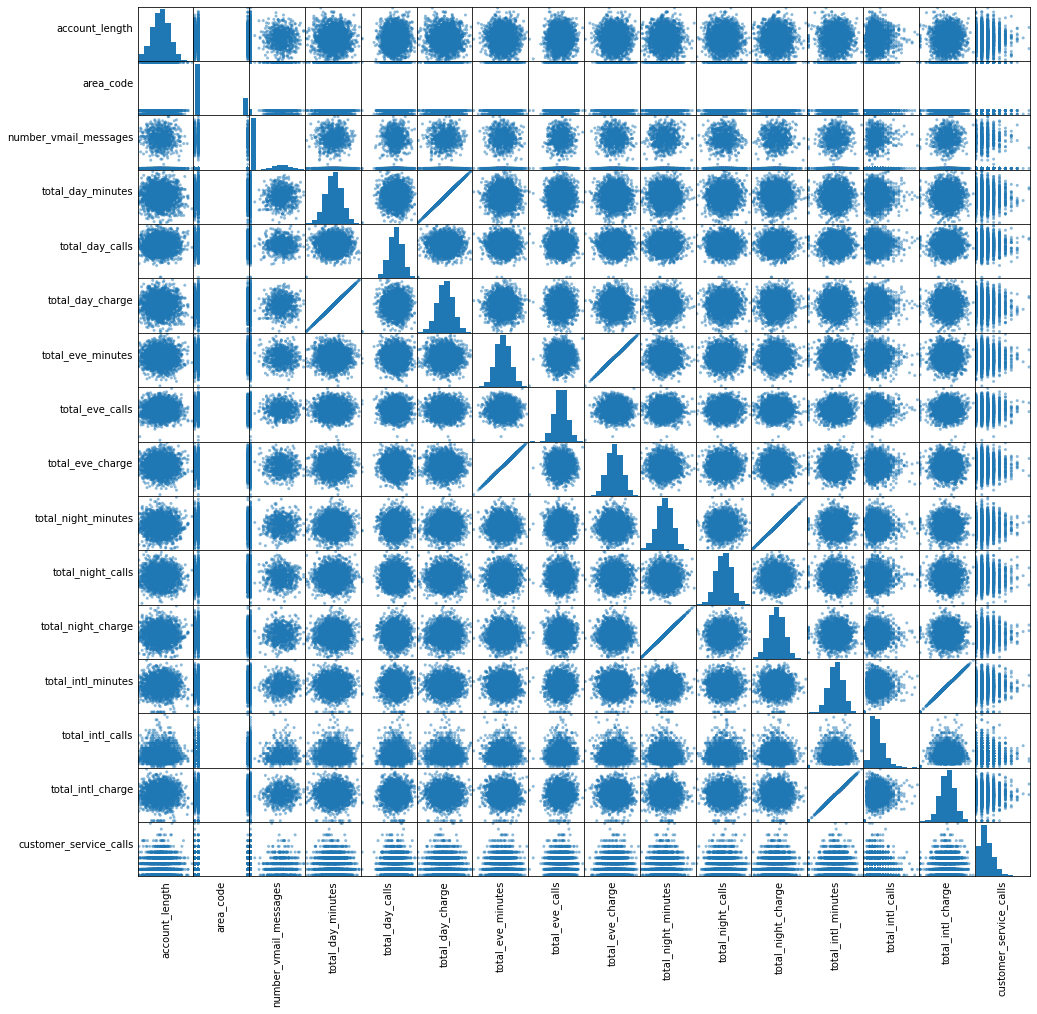

In [20]:
import matplotlib.pyplot as plt
axs=pd.plotting.scatter_matrix(num_data,figsize=(16,16))
n=len(num_data.columns)
for i in range(n):
    v=axs[i,0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    # X轴的label 垂直
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [15]:
import pandas as pd
data=train.union(test)
pd.DataFrame(data.take(5),columns=train.columns)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [16]:
#特征编码
from pyspark.ml.feature import StringIndexer
indexer =StringIndexer(inputCol ='state', outputCol= 'stateIndex')
data = indexer.fit(data).transform(data)
indexer =StringIndexer(inputCol ='international_plan', outputCol= 'international_planIndex')
data = indexer.fit(data).transform(data)
indexer =StringIndexer(inputCol ='voice_mail_plan', outputCol= 'voice_mail_planIndex')
data = indexer.fit(data).transform(data)
indexer =StringIndexer(inputCol ='churn', outputCol= 'churnIndex')
data = indexer.fit(data).transform(data)
pd.DataFrame(data.take(5))

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,...,11.01,10.0,3,2.70,1,False,16.0,0.0,1.0,0.0
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,...,11.45,13.7,3,3.70,1,False,4.0,0.0,1.0,0.0
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,...,7.32,12.2,5,3.29,0,False,20.0,0.0,0.0,0.0
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,...,8.86,6.6,7,1.78,2,False,4.0,1.0,0.0,0.0
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,...,8.41,10.1,3,2.73,3,False,35.0,1.0,0.0,0.0


In [21]:
data.show()

+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+----------+-----------------------+--------------------+----------+
|state|account_length|area_code|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|customer_service_calls|churn|stateIndex|international_planIndex|voice_mail_planIndex|churnIndex|
+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-----------

In [22]:
data=data.drop('state')

In [23]:
data=data.drop('international_plan')
data=data.drop('voice_mail_plan')
data=data.drop('churn')

In [25]:
data.show(5)

+--------------+---------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+----------+-----------------------+--------------------+----------+
|account_length|area_code|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|customer_service_calls|stateIndex|international_planIndex|voice_mail_planIndex|churnIndex|
+--------------+---------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+----------+-

In [28]:

pd.DataFrame(data.take(5),columns=data.columns)

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,stateIndex,international_planIndex,voice_mail_planIndex,churnIndex
0,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,16.0,0.0,1.0,0.0
1,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,4.0,0.0,1.0,0.0
2,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,20.0,0.0,0.0,0.0
3,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,4.0,1.0,0.0,0.0
4,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,35.0,1.0,0.0,0.0


In [36]:
## 决策树模型

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
feature=list(data.columns)[:-1]
assembler = VectorAssembler(inputCols=feature, outputCol='features')
train = assembler.transform(data).select('churnIndex', 'features')

In [37]:
train.show(5)

+----------+--------------------+
|churnIndex|            features|
+----------+--------------------+
|       0.0|[128.0,415.0,25.0...|
|       0.0|[107.0,415.0,26.0...|
|       0.0|[137.0,415.0,0.0,...|
|       0.0|[84.0,408.0,0.0,2...|
|       0.0|[75.0,415.0,0.0,1...|
+----------+--------------------+
only showing top 5 rows



In [38]:
splits = train.randomSplit([0.8, 0.2])
train = splits[0].cache()
test = splits[1].cache()

In [39]:
train.show()

+----------+--------------------+
|churnIndex|            features|
+----------+--------------------+
|       0.0|[1.0,415.0,0.0,19...|
|       0.0|[1.0,415.0,26.0,1...|
|       0.0|[1.0,415.0,30.0,1...|
|       0.0|[3.0,408.0,0.0,13...|
|       0.0|[3.0,415.0,0.0,18...|
|       0.0|[3.0,510.0,0.0,16...|
|       0.0|[3.0,510.0,27.0,6...|
|       0.0|[4.0,510.0,0.0,14...|
|       0.0|[5.0,415.0,0.0,19...|
|       0.0|[6.0,408.0,0.0,22...|
|       0.0|[9.0,408.0,31.0,1...|
|       0.0|[9.0,415.0,16.0,8...|
|       0.0|[10.0,510.0,0.0,1...|
|       0.0|[11.0,408.0,24.0,...|
|       0.0|[11.0,415.0,0.0,1...|
|       0.0|[11.0,415.0,28.0,...|
|       0.0|[11.0,510.0,38.0,...|
|       0.0|[12.0,415.0,0.0,2...|
|       0.0|[13.0,408.0,0.0,2...|
|       0.0|[13.0,415.0,0.0,5...|
+----------+--------------------+
only showing top 20 rows



In [46]:
model=DecisionTreeClassifier(featuresCol='features', labelCol='churnIndex',maxBins=60)
predict = model.fit(train).transform(test)
predict.show(5)

+----------+--------------------+-------------+--------------------+----------+
|churnIndex|            features|rawPrediction|         probability|prediction|
+----------+--------------------+-------------+--------------------+----------+
|       0.0|[1.0,408.0,0.0,12...|[1964.0,90.0]|[0.95618305744888...|       0.0|
|       0.0|[1.0,408.0,26.0,2...|[1964.0,90.0]|[0.95618305744888...|       0.0|
|       0.0|[7.0,415.0,0.0,20...|[1964.0,90.0]|[0.95618305744888...|       0.0|
|       0.0|[8.0,415.0,36.0,2...|[1964.0,90.0]|[0.95618305744888...|       0.0|
|       0.0|[9.0,415.0,39.0,2...|[1964.0,90.0]|[0.95618305744888...|       0.0|
+----------+--------------------+-------------+--------------------+----------+
only showing top 5 rows



In [48]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [50]:
evaluator = BinaryClassificationEvaluator(
    rawPredictionCol='prediction',
    labelCol='churnIndex',
    metricName='areaUnderROC')
print(evaluator.evaluate(predict))

0.7586607225782483
